<a href="https://colab.research.google.com/github/Chefiai/MSPR_SolutionIA_Wildlens/blob/main/MSPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [3]:
model = VGG16(weights='imagenet', include_top=True)

In [4]:
from sklearn.model_selection import train_test_split
import os
import shutil

dataset_path = '/content/drive/MyDrive/Mammifères'

train_path = '/content/drive/MyDrive/Mammifères/entrainement'
val_path = '/content/drive/MyDrive/Mammifères/validation'
test_path = '/content/drive/MyDrive/Mammifères/test'


os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

classes = os.listdir(dataset_path)

for classe in classes:
    # Chemin vers le répertoire de la classe dans le dataset
    class_path = os.path.join(dataset_path, classe)

    # Liste des fichiers dans le répertoire de la classe
    files = os.listdir(class_path)

    # Diviser les fichiers en ensembles d'entraînement, de validation et de test
    train_files, test_val_files = train_test_split(files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(test_val_files, test_size=0.5, random_state=42)

    # Chemins vers les répertoires de chaque ensemble
    train_class_path = os.path.join(train_path, classe)
    val_class_path = os.path.join(val_path, classe)
    test_class_path = os.path.join(test_path, classe)

    # Créer les répertoires pour chaque ensemble s'ils n'existent pas
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # Copier les fichiers dans les répertoires correspondants
for file in train_files:
    src_path = os.path.join(class_path, file)
    dst_path = os.path.join(train_class_path, file)
    if os.path.isfile(src_path):
        shutil.copy(src_path, dst_path)

for file in val_files:
    src_path = os.path.join(class_path, file)
    dst_path = os.path.join(val_class_path, file)
    if os.path.isfile(src_path):
        shutil.copy(src_path, dst_path)

for file in test_files:
    src_path = os.path.join(class_path, file)
    dst_path = os.path.join(test_class_path, file)
    if os.path.isfile(src_path):
        shutil.copy(src_path, dst_path)


In [5]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [6]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Définir les chemins vers vos données
train_data_dir = '/content/drive/MyDrive/Mammifères/entrainement'
valid_data_dir = '/content/drive/MyDrive/Mammifères/validation'
test_data_dir = '/content/drive/MyDrive/Mammifères/test'

# Définir vos classes
class_subset = sorted(os.listdir(train_data_dir))[:10]  # Utiliser seulement les 10 premières classes

# Définir les paramètres du générateur
BATCH_SIZE = 32

# Créer des instances de ImageDataGenerator pour l'entraînement, la validation et les tests
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Créer les générateurs d'images
traingen = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    class_mode='categorical',
    classes=class_subset,
    subset='training',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

validgen = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(224, 224),
    class_mode='categorical',
    classes=class_subset,
    subset='validation',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

testgen = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    class_mode=None,
    classes=class_subset,
    batch_size=1,
    shuffle=False,
    seed=42
)


Found 132 images belonging to 10 classes.
Found 0 images belonging to 10 classes.
Found 34 images belonging to 10 classes.


In [8]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [9]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=10

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 10

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [10]:
!pip install livelossplot
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

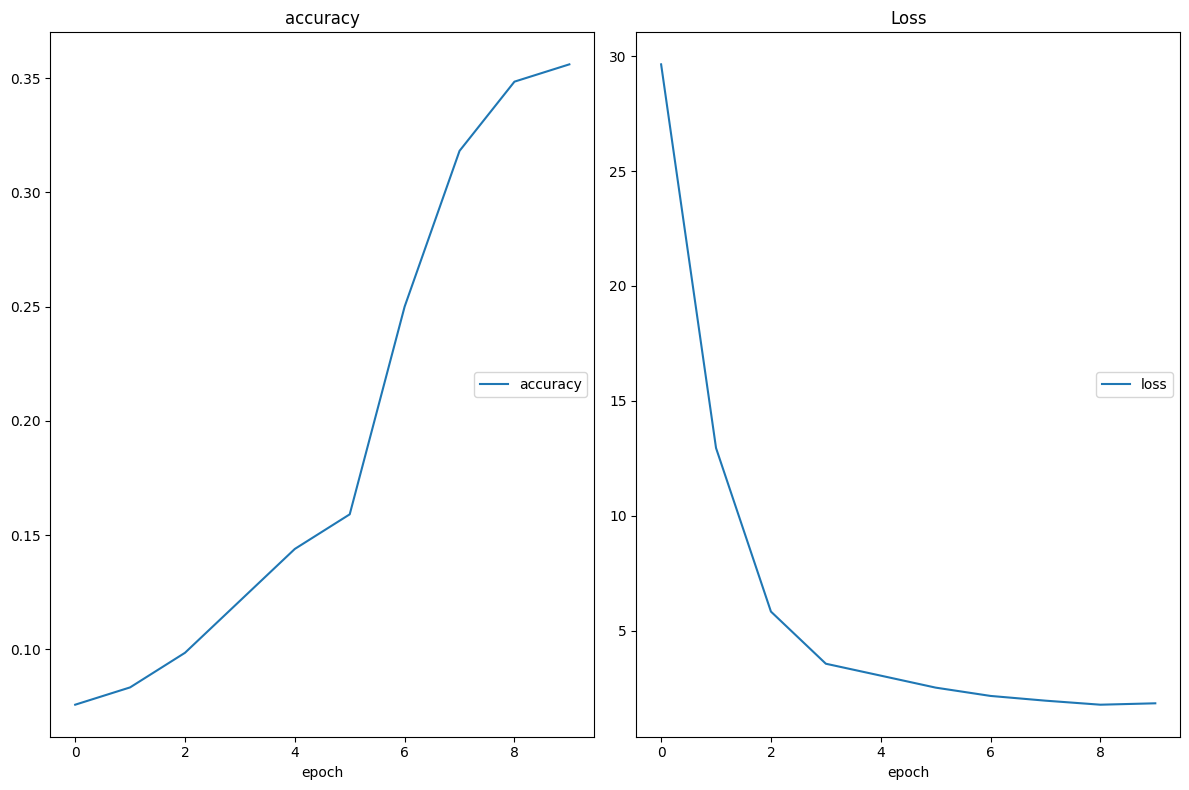

accuracy
	accuracy         	 (min:    0.076, max:    0.356, cur:    0.356)
Loss
	loss             	 (min:    1.787, max:   29.639, cur:    1.848)
5/5 [==============================] - 104s 19s/step - loss: 1.8482 - accuracy: 0.3561
CPU times: user 24min 21s, sys: 2min 39s, total: 27min
Wall time: 20min 59s


In [13]:
%%time
n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=10,
                            validation_data=validgen,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

Using Pre-trained Layers for Fine-Tuning


In [11]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_2 = Adam(learning_rate=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

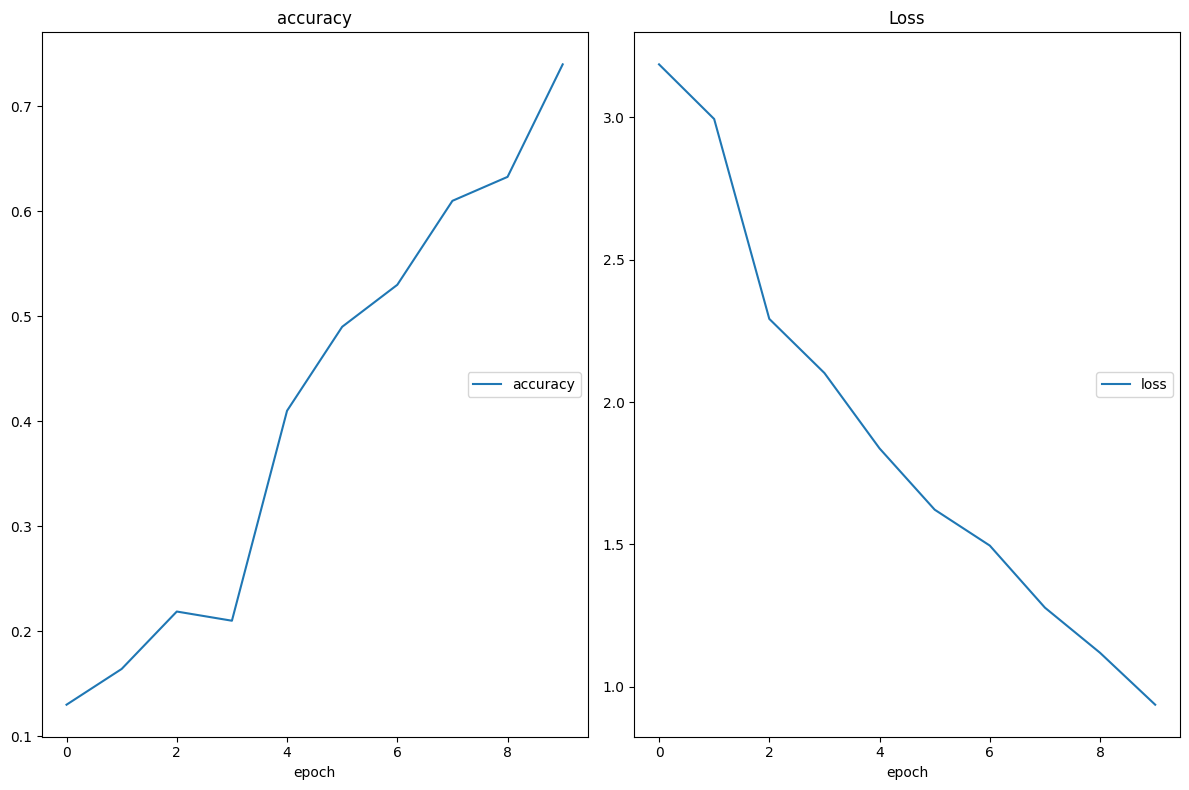

accuracy
	accuracy         	 (min:    0.130, max:    0.740, cur:    0.740)
Loss
	loss             	 (min:    0.937, max:    3.186, cur:    0.937)
4/4 [==============================] - 81s 18s/step - loss: 0.9375 - accuracy: 0.7400
CPU times: user 21min 25s, sys: 1min 57s, total: 23min 23s
Wall time: 18min 45s


In [12]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [15]:
!ls

drive  sample_data


In [16]:
from sklearn.metrics import accuracy_score, classification_report

# Charger les poids du modèle VGG16
model = VGG16(weights='imagenet', include_top=True)

# Obtenir les prédictions du modèle sur l'ensemble de test
vgg_pred_probs = vgg_model.predict(testgen)
vgg_pred_classes = vgg_pred_probs.argmax(axis=-1)  # Obtenez la classe prédite pour chaque échantillon

# Obtenir les vraies classes de l'ensemble de test
true_classes = testgen.classes

# Calculer l'exactitude
vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy on Test Set: {:.2f}%".format(vgg_acc * 100))

# Afficher le rapport de classification
print("Classification Report:\n", classification_report(true_classes, vgg_pred_classes))


34/34 [==============================] - 26s 747ms/step
VGG16 Model Accuracy on Test Set: 14.71%
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         4
           3       0.33      0.50      0.40         4
           4       0.17      0.33      0.22         3
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         4
           8       0.10      0.50      0.16         4
           9       0.00      0.00      0.00         4

    accuracy                           0.15        34
   macro avg       0.06      0.13      0.08        34
weighted avg       0.07      0.15      0.09        34



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
